In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import pandas as pd
import os
import numpy as np
import pickle as pk
import sklearn as sk
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
from sklearn.utils import shuffle


2023-05-27 00:39:35.945227: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-27 00:39:36.568791: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data = pd.read_csv("./../codes/semantic.csv")

shuffle(data)
data.dropna()
data.head()
print( tf.config.list_physical_devices())
data.shape

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


2023-05-27 00:39:38.890067: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


(300200, 33)

In [61]:
tf.random.set_seed(12)
tf.keras.backend.clear_session()
x = data.iloc[0:, 0:32].values.astype("float64").reshape(-1,2,16,1)
y = data.iloc[0:, 32].values.astype("bool")

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42,
                                                    shuffle=True)

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu',input_shape=(2,16)),
    Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    Dropout(0.2),
    Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.0025),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [62]:
history = model.fit(x_train, y_train,validation_data=(x_test, y_test), epochs=60)

Epoch 1/60
6567/6567 [==============================] - 9s 1ms/step - loss: 0.6144 - accuracy: 0.6451 - val_loss: 0.5928 - val_accuracy: 0.6594
Epoch 2/60
6567/6567 [==============================] - 9s 1ms/step - loss: 0.5852 - accuracy: 0.6698 - val_loss: 0.5514 - val_accuracy: 0.6974
Epoch 3/60
6567/6567 [==============================] - 9s 1ms/step - loss: 0.5433 - accuracy: 0.7070 - val_loss: 0.5118 - val_accuracy: 0.7406
Epoch 4/60
6567/6567 [==============================] - 9s 1ms/step - loss: 0.5082 - accuracy: 0.7380 - val_loss: 0.4433 - val_accuracy: 0.7979
Epoch 5/60
6567/6567 [==============================] - 9s 1ms/step - loss: 0.4739 - accuracy: 0.7645 - val_loss: 0.4143 - val_accuracy: 0.8126
Epoch 6/60
6567/6567 [==============================] - 9s 1ms/step - loss: 0.4437 - accuracy: 0.7843 - val_loss: 0.3700 - val_accuracy: 0.8444
Epoch 7/60
6567/6567 [==============================] - 9s 1ms/step - loss: 0.4209 - accuracy: 0.8002 - val_loss: 0.3459 - val_accuracy:

In [55]:

y_pred = model.evaluate(x_test,y_test)


2815/2815 [==============================] - 2s 536us/step - loss: 0.0764 - accuracy: 0.9792


2815/2815 [==============================] - 1s 438us/step
              precision    recall  f1-score   support

       False       0.98      0.98      0.98     45063
        True       0.98      0.98      0.98     44997

    accuracy                           0.98     90060
   macro avg       0.98      0.98      0.98     90060
weighted avg       0.98      0.98      0.98     90060

AUC-ROC: 0.9983269165477079


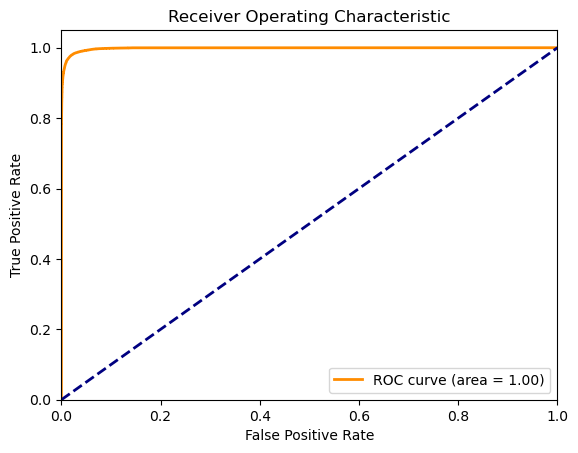

In [56]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Assuming that 'model' is your trained model and 'X_test', 'y_test' are your test data.

# Predict the probabilities for the test data
y_pred_prob = model.predict(x_test).ravel()

# Predict the classes for the test data
y_pred = np.round(y_pred_prob)

# Print precision, recall, and F1-score
print(classification_report(y_test, y_pred))

# Calculate AUC-ROC
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("AUC-ROC:", roc_auc)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure()
lw = 2  # Line width
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

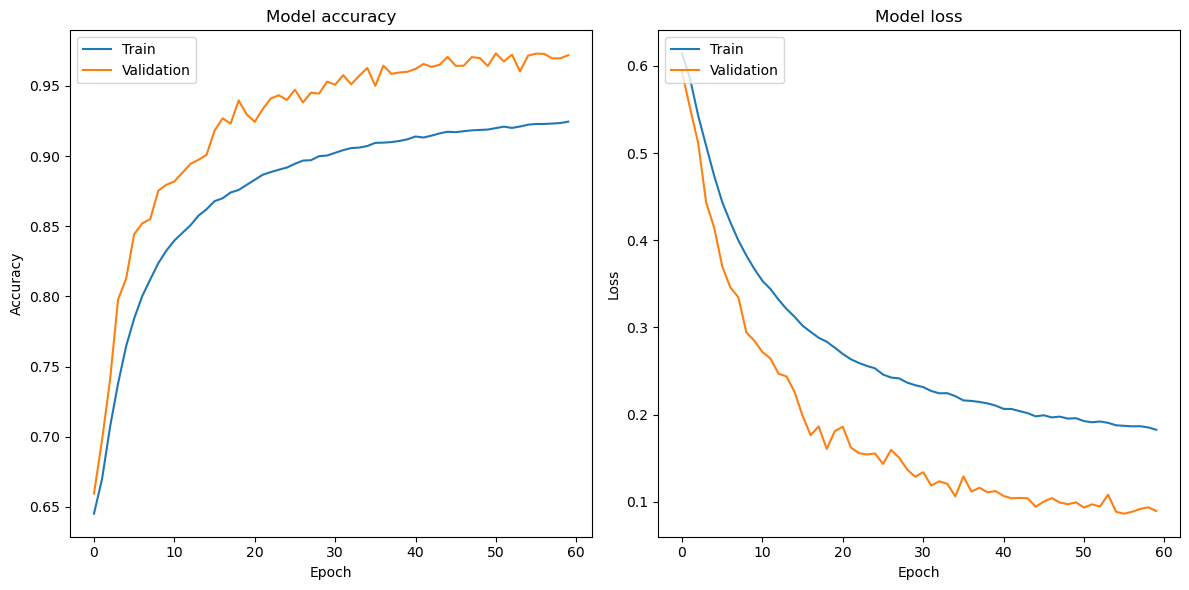

In [64]:
import matplotlib.pyplot as plt

# Assuming that 'model' is your trained model, and 'history' is the returned History object from model.fit
# e.g., history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20)

# Plot training & validation accuracy values
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [58]:
history.history

{'loss': [0.6074344515800476,
  0.5667263269424438,
  0.5221114754676819,
  0.4826290011405945,
  0.44699203968048096,
  0.41893401741981506,
  0.3964265286922455,
  0.3789557218551636,
  0.36121776700019836,
  0.3470751643180847,
  0.33298352360725403,
  0.3189552426338196,
  0.30589011311531067,
  0.2960169315338135,
  0.28950634598731995,
  0.28056561946868896,
  0.274003803730011,
  0.2686571776866913,
  0.26343250274658203,
  0.25946885347366333,
  0.25241175293922424,
  0.24821750819683075,
  0.24244168400764465,
  0.24143515527248383,
  0.23254837095737457,
  0.2322567254304886,
  0.2273981273174286,
  0.22330018877983093,
  0.21991068124771118,
  0.21680310368537903,
  0.21312835812568665,
  0.21211619675159454,
  0.21073231101036072,
  0.2086533159017563,
  0.20455782115459442,
  0.20295074582099915,
  0.20086164772510529,
  0.19895052909851074,
  0.19738855957984924,
  0.1956952065229416,
  0.19320417940616608,
  0.19183355569839478,
  0.19120913743972778,
  0.187018826603889

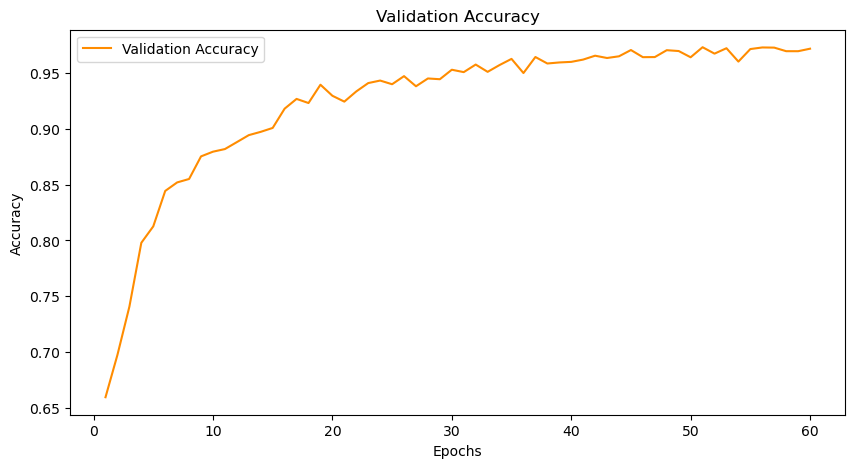

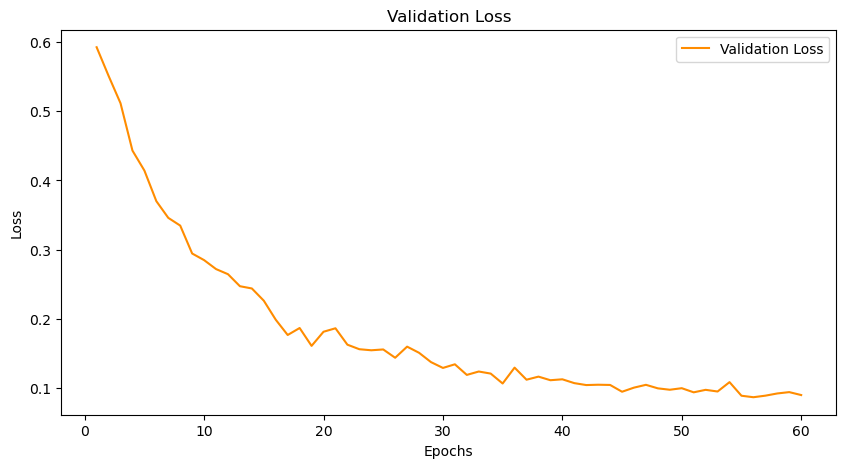

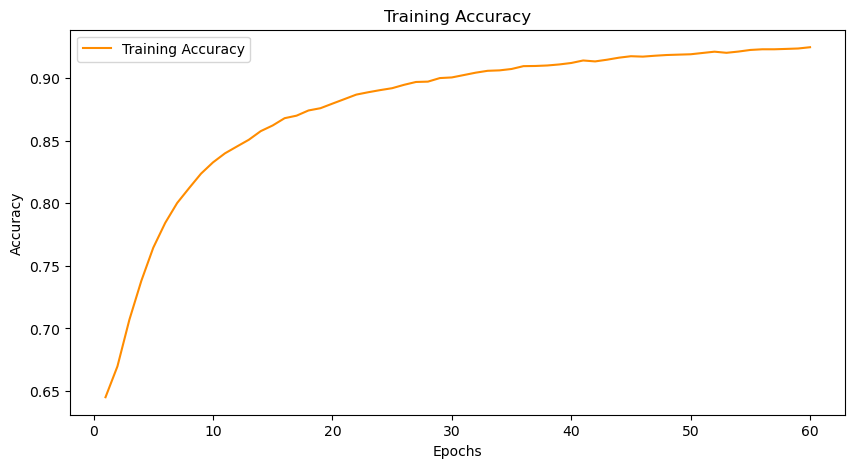

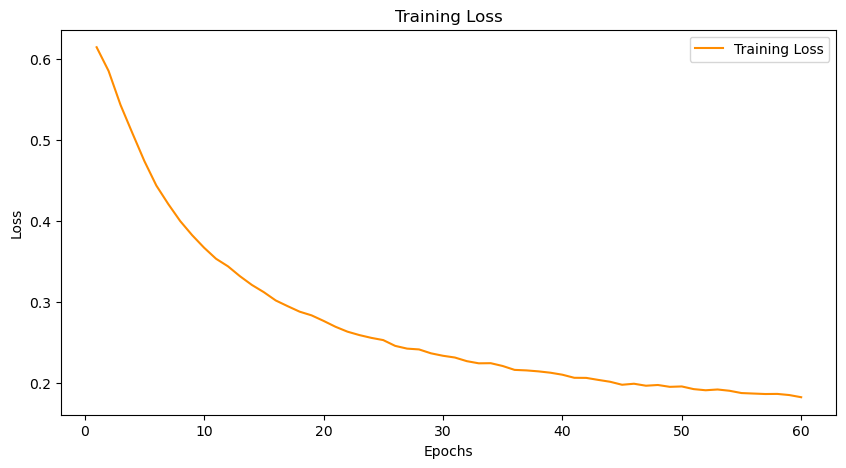

In [63]:
import matplotlib.pyplot as plt

# Extracting metrics from the history object
validation_accuracy = history.history['val_accuracy']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
training_loss = history.history['loss']

# Getting the number of epochs
num_epochs = len(validation_accuracy)

# Plotting validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), validation_accuracy, label='Validation Accuracy', color="darkorange")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

# Plotting validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), validation_loss, label='Validation Loss', color="darkorange")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.show()

# Plotting training accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_accuracy, label='Training Accuracy', color="darkorange")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

# Plotting training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_loss, label='Training Loss', color="darkorange")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()
